In [1]:
#! /usr/bin/env python3

import os
import re
from math import log10, floor

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from adjustText import adjust_text

from criteria import criteria

In [2]:
def get_label(df):
    """
    Get the description of each point based on the data frame.
    If multiple parameters give the same output, the parameter p is denoted as :
        p = a,b,c
    a,b,c being the possible values of the parameter.
    """

    def round_sig(x, sig=2):
        """Round x to a certain amount of significant digits."""
        return round(x, sig - int(floor(log10(abs(x)))) - 1)

    df.dropna(axis=1, how="all", inplace=True)

    shorten = {"ababove-thld_pixels": "pixels",
               "above-thld_pixels_std": "std"}

    text = []
    for c in df.columns:
        values = [str(v) for v in df[c]]

        # try to reduce values' length
        for i in range(len(values)):
            try:
                values[i] = float(values[i])
                if values[i] == int(values[i]):
                    values[i] = int(float(values[i]))
                else:
                    values[i] = round_sig(values[i], 3)
                    if values[i] < 0.1:
                        values[i] = "{:e}".format(values[i])
                        values[i] = re.sub(r"(0+e)", "e", values[i])
                        values[i] = re.sub(r"(\.e)", "e", values[i])
                        values[i] = re.sub(r"(\.0+)$", "", values[i])
            except:
                pass
            finally:
                values[i] = str(values[i])
        if c in shorten.keys():
            text.append(shorten[c] + '=' + ", ".join(sorted(list(set(values)))))
        else:
            text.append(c + '=' + ", ".join(sorted(list(set(values)))))
    return text

In [3]:
def get_title_and_text(list_text, plot_title):
    """
    If a parameter's value is the same for every point, add it to the title.
    This allows to save some space on the plot.
    """
    def split_long_strings(long_text, max_length = 33) :
        text = []
        for lt in long_text :
            if len(lt) < max_length :
                text.append(lt)
            else :
                splited_lt = lt.split(" ")
                splited_lt.reverse()
                new_lt = []
                while len(splited_lt) > 0 :
                    new_lt.append('')
                    while len(new_lt[-1]) + len(splited_lt[-1]) < max_length :
                        new_lt[-1] += splited_lt.pop() + " "
                        if len(splited_lt) == 0 :
                            break
                for nlt in new_lt :
                    text.append(nlt)
        return text
    
    set_text = set(list_text[0])
    for l in list_text[1:]:
        set_text = set_text & set(l)
    if len(set_text) != 0:
        plot_title = plot_title + " - " + "; ".join(list(set_text))
        for s in set_text:
            for i in range(len(list_text)):
                if s in list_text[i]:
                    list_text[i].remove(s)

    for i in range(len(list_text)):
        list_text[i] = split_long_strings(list_text[i])
        list_text[i] = "\n".join(list_text[i])

    return (list_text, plot_title)

In [4]:
def parse_key(key):
    """
    Change the dictionary's keys to shorter or more descriptive keys.
    """
    true_key = {"debiased_sink_bary": "Debiased Sinkhorn",
                "entropic_reg_bary": "Entropic Regularized",
                "kbcm_bary": "KBCM",
                "tlp_bary": "TLp-BI",
                "imgs": "samples",
                "eps": "epsilon",
                "bary noiselvl": "noise_level",
                "bary lvl": "noise_level",
                "noiselvl": "noise_level",
                "lvl": "noise_level"}
    if key in true_key.keys():
        return true_key[key]
    else:
        return key


In [5]:
def get_files(path="./data"):
    """
    Get the barycenters files.
    """
    directories = [f for f in os.listdir(path) if not os.path.isfile(os.path.join(path, f))]
    if "noisefrees_control" in directories:
        directories.remove('noisefrees_control')
    if "entropic_reg_bary_convol" in directories:
        directories.remove("entropic_reg_bary_convol")

    tree = {d: [] for d in directories}

    for d in directories:
        tree[d] = [f for f in os.listdir(os.path.join(path, d)) if os.path.isfile(os.path.join(path, d, f))]
        tree[d] = [file for file in tree[d] if file[-4:] == ".npy"]
        tree[d].sort()

    return tree

In [16]:
def collect(path="./data/", save=True, save_path="./results/"):
    """
    Collect the data from the barycenter's files.
    Then summarize everything in a DataFrame and save it (if save==True) as a file.
    """
    def adapted_l2_obv_thr_pixels_std(v):
        if v is None :
            return None
        else :
            return np.sqrt(v[0] ** 2 + v[1] ** 2)
    
    def adapted_l2_center_dist(v):
        if v is None :
            return None
        else :
            v = v - 24.5
            return np.sqrt(v[0] ** 2 + v[1] ** 2)
    
    tree = get_files(path)
    data = {d: np.array([np.load(os.path.join(path, d, file)) for file in tree[d]]) for d in tree.keys()}

    # data = filter_nan(data)
    # data = standardize.main(data)

    df = pd.DataFrame(columns=["noise_level",
                               "max_amplitude",
                               "center_distance",
                               "above-thld_pixels",
                               "above-thld_pixels_std",
                               "algorithm"])
    for d in tree.keys():
        for file_name, barycenter in zip(tree[d], data[d]):
            param = dict({"algorithm": parse_key(d)})

            name = file_name[:-4]

            name = re.sub(r"_noise_lvls_\d", "", name)
            name = re.sub(r"bary_", "", name)

            groups = re.findall(
                r"((?:[a-zA-Z](?:[a-zA-Z]|_|-)+_(?:[+-]?\d+(?:\.\d+)?)+|(?:intensity_(?:minmax|zeroone))))", name)

            for g in groups:
                key = ' '.join(re.findall(r"((?:[a-zA-Z]+(?:_|-))+)", g))
                value = re.sub(key, '', g)
                key = re.sub(r"((?:_)$)", "", key)

                if key not in ["mean"]:
                    try:
                        if int(float(value)) == float(value):
                            param[parse_key(key)] = int(float(value))
                        else:
                            param[parse_key(key)] = float(value)
                    except ValueError:
                        param[parse_key(key)] = value

            max_ampl, barycenter_loc, pixels, std = criteria(barycenter)
            
            param["max_amplitude"] = max_ampl
            param["center_distance"] = adapted_l2_center_dist(barycenter_loc)
            param["above-thld_pixels"] = pixels
            param["above-thld_pixels_std"] = adapted_l2_obv_thr_pixels_std(std)
            param["file_name"] = d+"/"+file_name
            
            df = df.append(param, ignore_index=True)
    
    df = df[df['max_amplitude'].notna()]
    
    if save:
        df.to_csv(os.path.join(save_path, "DataFrame_summary.csv"), index=False)

    return df


In [7]:
def compare_max_amplitude(df,
                          show_plot=True,
                          save_plot=True,
                          show_points_params=True):
    """
    Compare the max amplitude of the barycenter's for each algorithms.
    """
    make_plot(df=df,
              min_or_max="max",
              variable="max_amplitude",
              show_plot=show_plot,
              save_plot=save_plot,
              show_points_params=show_points_params)


In [8]:
def compare_obv_thr_pixels(df,
                           show_plot=True,
                           save_plot=True,
                           show_points_params=True):
    """
    Compare the number of pixels above threshold (threshold = 1/2 * max_amplitude).
    The smallest number of pixels above threshold is best as we want a sharp barycenter.
    """
    
    df = df[df["above-thld_pixels"].notna()]
    
    make_plot(df=df,
              min_or_max="min",
              variable="above-thld_pixels",
              show_plot=show_plot,
              save_plot=save_plot,
              show_points_params=show_points_params)

In [9]:
def compare_obv_thr_pixels_std(df,
                               show_plot=True,
                               save_plot=True,
                               show_points_params=True):
    """
    Compare the standard deviation of the pixels above threshold (threshold = 1/2 * max_amplitude).
    Get the minimum std for each algorithm.
    The smallest activation zone is better as we want a sharp barycenter.
    """   
    
    df = df[df["above-thld_pixels_std"].notna()]

    make_plot(df=df,
              min_or_max="min",
              variable="above-thld_pixels_std",
              show_plot=show_plot,
              save_plot=save_plot,
              show_points_params=show_points_params)

In [10]:
def compare_center_distance(df,
                            show_plot=True,
                            save_plot=True,
                            show_points_params=True):
    """
    Compare the barycenter's distance to the image's center.
    We generate the data so that the barycenters are determined to be in the center of the image (24.5,24.5)
    as long as we compute it on the n'th first images, n even.
    We then compare the smallest l2 norm between the barycenter's center and the image's center.
    The barycenter's center is computed as the weighted average of all the above threshold pixels.
    """

    

    df = df[df['center_distance'].notna()]
    
    make_plot(df=df,
              min_or_max="min",
              variable="center_distance",
              show_plot=show_plot,
              save_plot=save_plot,
              show_points_params=show_points_params)

In [11]:
def make_plot(df,
              min_or_max,
              variable,
              show_plot=True,
              save_plot=True,
              show_points_params=True,
              log_bests=True):
    """
    Make the plot for any comparison.
    If show_points_params==True, show the parameters of the algorithms for a each point.
    """
    print(f"\n*** Making plot for variable : {variable}.***\n")
    
    df = pd.DataFrame(df)
    
    df = df[df['max_amplitude'].notna()]
    
    to_be_droped = list({"file_name",
                         "center_distance",
                         "above-thld_pixels",
                         "above-thld_pixels_std"} - {variable})

    sub_df = pd.DataFrame(columns=["noise_level",
                                   "algorithm",
                                   "file_name",
                                   variable])
 

    for noise_lvl in sorted(list(df["noise_level"].unique())):
        sub_noise_df = df[df["noise_level"] == noise_lvl]

        for algo in sorted(list(sub_noise_df["algorithm"].unique())):
            sub_algo_noise_df = sub_noise_df[sub_noise_df["algorithm"] == algo]
            if min_or_max == "min":
                maxminimum = sub_algo_noise_df[variable].min()
            elif min_or_max == "max":
                maxminimum = sub_algo_noise_df[variable].max()

            sub_df = sub_df.append(sub_algo_noise_df.loc[sub_algo_noise_df[variable] == maxminimum])
    
    if log_bests :
        sub_df.to_csv(f"./results/Logs_best_{variable}.csv")
        
    df = df.drop(to_be_droped, axis=1)
    sub_df = sub_df.drop(to_be_droped, axis=1)

    if variable != "max_amplitude" :
        sub_df = sub_df.drop("max_amplitude",axis=1)
        df = df.drop("max_amplitude",axis=1)

    sub_df.drop_duplicates(inplace=True)
    sub_df.sort_values(by=["noise_level"], inplace=True)

    nb_algo = len(sub_df["algorithm"].unique())

    plt.figure(1, figsize=(18, 1 + 2 * nb_algo))
    colors = ["red", "green", "blue", "magenta", "orange", "cyan"]
    i = 0

    for algo in sorted(list(sub_df["algorithm"].unique())) :
        plt.subplot(nb_algo, 1, i + 1)
        sub_algo_variable_df = pd.DataFrame(sub_df[sub_df['algorithm'] == algo])
        sub_algo_variable_df.dropna(axis=1, how='any', inplace=True)
        x = sub_algo_variable_df["noise_level"]
        y = sub_algo_variable_df[variable]
        label = algo
        plot_title = algo
        plt.plot(x, y, label=label, color=colors[i], marker='D', alpha=.5)

        # print the parameters on the plot
        if show_points_params:
            j = 0
            texts = []
            s_s = []
            x_s = []
            y_s = []
            for noise_lvl in sub_algo_variable_df["noise_level"].unique():
                sub_algo_noise_variable_df = pd.DataFrame(
                    sub_algo_variable_df[sub_algo_variable_df['noise_level'] == noise_lvl])
                text_param = get_label(sub_algo_noise_variable_df.drop(['noise_level',
                                                                        'algorithm'], axis='columns'))
                s_s.append(text_param)
                x_s.append(noise_lvl)
                y_s.append(sub_algo_noise_variable_df[variable].iloc[0])
                j += 1

            list_text, plot_title = get_title_and_text(list(s_s), plot_title)
            for k in range(j):
                t = plt.text(x=x_s[k] + 0.01,
                             y=y_s[k],
                             s=list_text[k],
                             color=colors[i],
                             rotation=0)
                t.set_bbox(dict(facecolor='white',
                                alpha=0.5,
                                edgecolor='gray',
                                boxstyle='round'))
                texts.append(t)
        i += 1
        adjust_text(texts,
                    precision=1e-5,
                    expand_text=(1.1, 1.25),
                    expand_points=(1.1, 1.25),
                    expand_objects=(1.1, 1.25),
                    expand_align=(1.1, 1.25))
        # plt.legend()
        plt.title(plot_title, fontsize=10.0)  # , fontweight='bold')
        plt.ylabel(variable)
        plt.xlim(left=df["noise_level"].unique().min(), right=df["noise_level"].unique().max())
        if i < nb_algo :
            plt.xticks([0,1])
        else :
            plt.xticks(sorted(list(df["noise_level"].unique())))

    plt.xlabel("noise_level")

    title = "Compare_{}_{}".format("maximum" if min_or_max == 'max' else "minimum", variable, )

    # plt.tight_layout()
    plt.suptitle(title + "\n\
                 noise_level in ({})".format(', '.join([str(n) for n in df['noise_level'].unique()])),
                 fontsize=15.0)  # , fontweight='bold')
    if save_plot:
        plt.savefig("./results/" + title + ".png")
    if show_plot:
        plt.show()
    plt.close()

In [12]:
def compare_all(df=None,
                re_collect=True,
                max_ampl=True,
                obv_thl_pix=True,
                obv_thl_pix_std=True,
                center_dist=True,
                show_plots=False):
    """
    Run all the comparisons.
    """
    if re_collect :
        print("\n\n","="*50,"\n\n")
        print("\nRe-collect the data from the computed barycenters.")
        df = collect("../test_algos/results")
        print("DONE")

    if max_ampl:
        print("\n\n","="*50,"\n\n")
        print("\nPlot the maximum amplitude of each algorithm for each noise level.")
        compare_max_amplitude(df=df, show_plot=show_plots)
        print("DONE")

    if obv_thl_pix:
        print("\n\n","="*50,"\n\n")
        print("\nPlot the minimum size of the blobs (above threshold pixels) of each algorithm for each noise level.")
        compare_obv_thr_pixels(df=df, show_plot=show_plots)
        print("DONE")

    if obv_thl_pix_std:
        print("\n\n","="*50,"\n\n")
        print("\nPlot the minimum standard deviation of the blobs (above threshold pixels) of each algorithm for each noise level.")
        compare_obv_thr_pixels_std(df=df, show_plot=show_plots)
        print("DONE")

    if center_dist:
        print("\n\n","="*50,"\n\n")
        print("\nPlot the minimum distance between the barycenter and the theoretical, deterministic, barycenter of each algorithm for each noise level.")
        compare_center_distance(df=df, show_plot=show_plots)
        print("DONE")
    
    if re_collect :
        return df







Re-collect the data from the computed barycenters.
DONE





Plot the maximum amplitude of each algorithm for each noise level.

*** Making plot for variable : max_amplitude.***



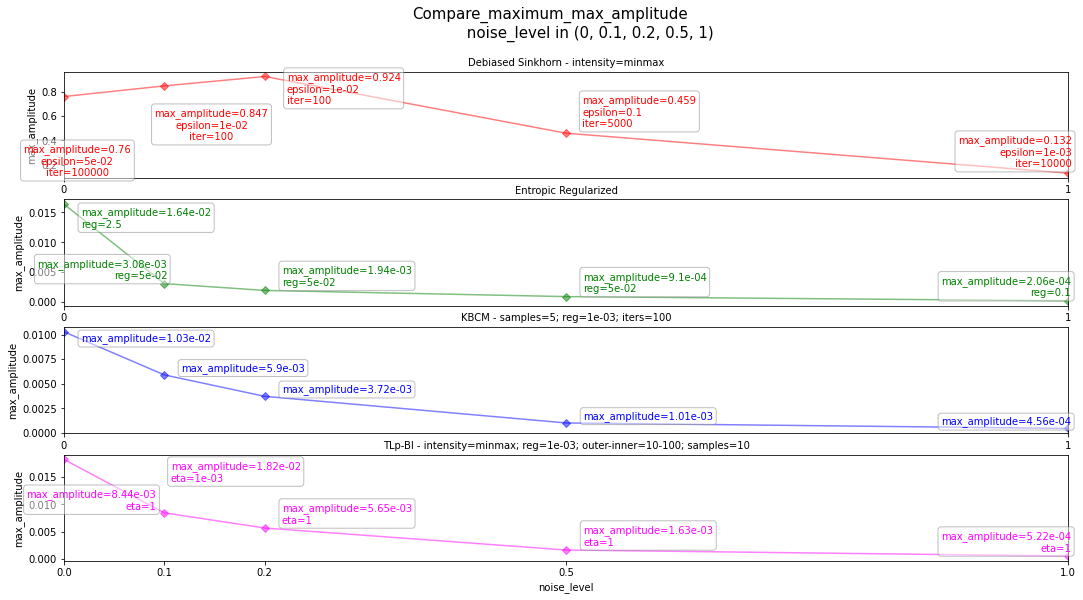

DONE





Plot the minimum size of the blobs (above threshold pixels) of each algorithm for each noise level.

*** Making plot for variable : above-thld_pixels.***



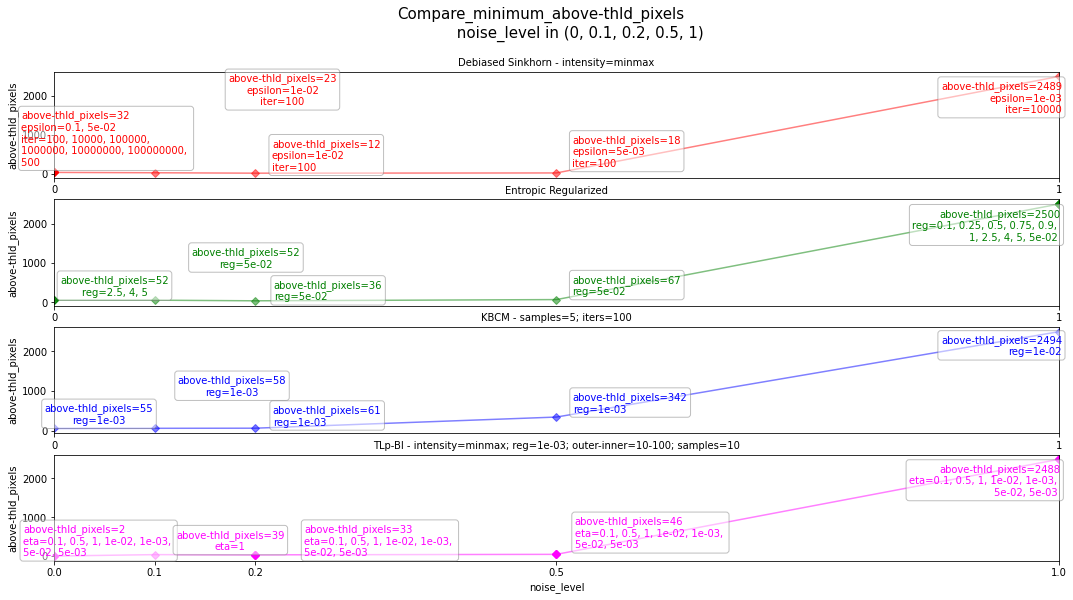

DONE





Plot the minimum standard deviation of the blobs (above threshold pixels) of each algorithm for each noise level.

*** Making plot for variable : above-thld_pixels_std.***



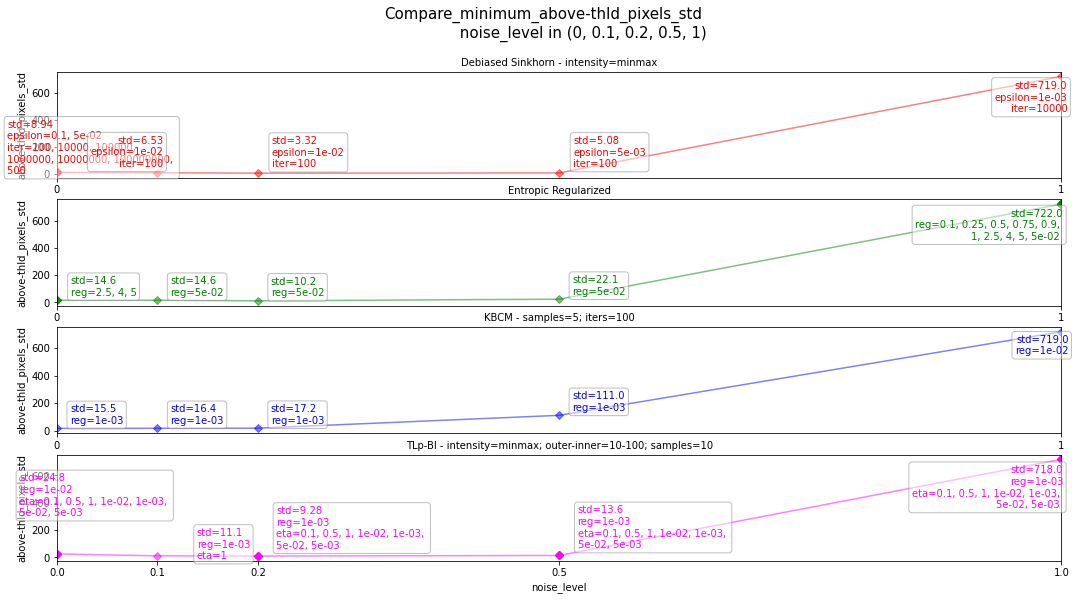

DONE





Plot the minimum distance between the barycenter and the theoretical, deterministic, barycenter of each algorithm for each noise level.

*** Making plot for variable : center_distance.***



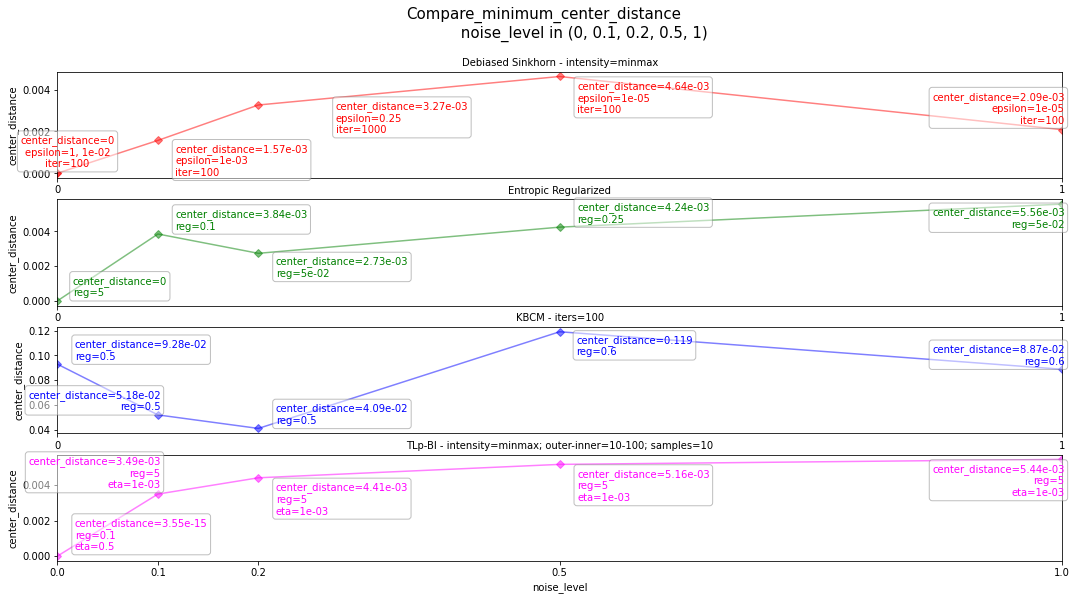

DONE


In [17]:
if __name__ == "__main__":
    df = compare_all()